In [1]:
import matplotlib, sys,  os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
sys.path.append("./mylib/")
sys.path.append("../../Env/")

import numpy as np
import matplotlib.pyplot as plt

np.seterr(all="ignore")
from threeML import *
from WCDA_hal import HAL, HealpixConeROI, HealpixMapROI
import traceback
silence_warnings()
import warnings
warnings.simplefilter("ignore")
silence_warnings()
from threeML import silence_progress_bars, activate_progress_bars, toggle_progress_bars
from threeML.utils.progress_bar import trange

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
# from astropy.visualization import astropy_mpl_style, imshAow_norm
from astropy.coordinates import Angle

import healpy as hp

from tqdm import tqdm

# from mylib import *
import mylib as my
from importlib import reload

Welcome to JupyROOT 6.24/06


15:19:53 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=975628;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=152537;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#50\50]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=802490;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=240298;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#71\71]8;;\
                  will not be available.                                                                           

15:19:54 WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=677705;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=116198;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py#36\36]8;;\
                  available                                                                                        

15:19:54 INFO      Starting 3ML!                                                                     ]8;id=461530;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=71151;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=335206;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=328548;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=617332;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=418024;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=913460;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=746934;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/threeML/__init__.py#40\40]8;;\

15:19:55 WARNING   Multinest minimizer not available                                           ]8;id=851823;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=484485;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=92187;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=725562;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

15:19:55 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=504862;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=174378;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=153017;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=273080;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

Load sub from Myspeedup: 100%|██████████| 37/37 [00:00<00:00, 73.30it/s]   

Yourlib init successfully!!!


Load sub from Myspeedup: 100%|██████████| 37/37 [00:19<00:00, 73.30it/s]

Load sub from Myspeedup: 100%|██████████| 37/37 [00:20<00:00, 35.64it/s]

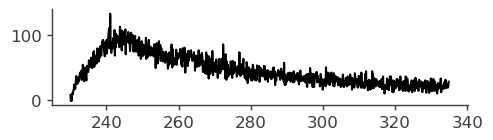

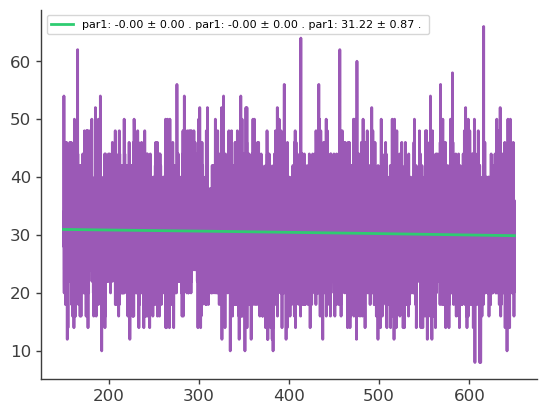

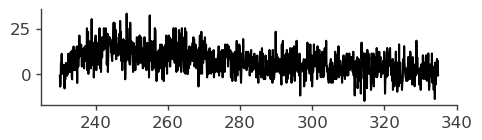

100%|██████████| 7000/7000 [00:00<00:00, 7431.69it/s]


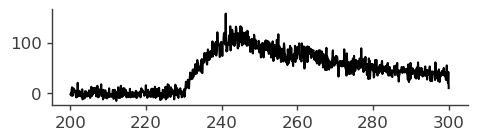

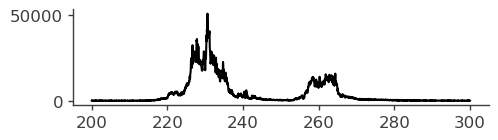

In [2]:
%matplotlib inline
GRB221009A = my.lc("../../data/lc_data/GRB221009A/GRBlcunbin.root", ebin=11, funcfile="../../data/lc_data/GRB221009A/func.root") #funcfile="../../data/lc_data/GRB221009A/bkg.npy"
GRB221009A.rebin(1000)
GRB221009A.drawlc()
GRB221009A_trig = my.lc("../../data/lc_data/GRB221009A/1009_nf_dt.root", tname="h;1", bkgfile="../../data/lc_data/GRB221009A/1008_nf_dt.root", bkgscale=2)
GRB221009A_trig.rebin(1000)
GRB221009A_trig.fitbkg(my.poly , 150, 650, p0=[2, 2, 20], plot=True)
plt.figure()
GRB221009A_trig.drawlc()
GRB221009Aall = GRB221009A + GRB221009A_trig
GRB221009Aall.drawlc(200,300)
GRB221009A_prompr = my.lc('../../data/lc_data/GRB221009A/hebs-2.txt')
GRB221009A_prompr.drawlc(200,300)

In [ ]:
GRB221009A.bkgpar

-0.030299038611905568

In [122]:
datafgrb = GRB221009Aall.getdatafram(subbkg=False)
datafgrb = datafgrb[(datafgrb["x"]>=150) & (datafgrb["x"]<=600)]

11:22:42 INFO      Using Poisson log-likelihood                                                       ]8;id=547749;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/plugins/XYLike.py\XYLike.py]8;;\:]8;id=568138;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/plugins/XYLike.py#111\111]8;;\

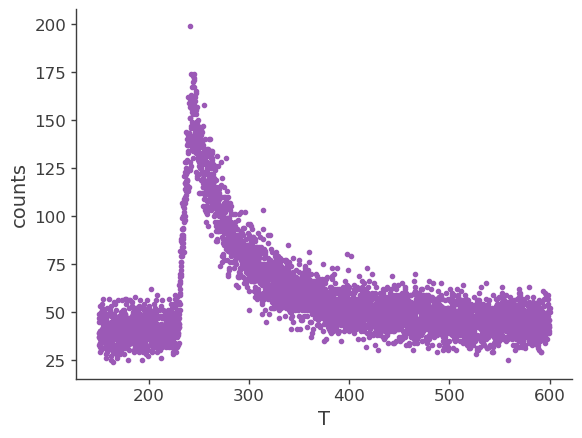

In [123]:
GRBlike = XYLike.from_dataframe("GRB221009A", datafgrb, poisson=True)
fig = GRBlike.plot(x_label="T", y_label="counts")

In [120]:
lcmodel = my.SBPL()
lcmodel.alpha1.bounds = (0,10)
lcmodel.alpha2.bounds = (-10,0)
lcmodel.F0.bounds = (0.1,10000)
lcmodel.t0=230
lcmodel.t0.bounds = (225, 235)
lcmodel.t0.fix=True
gauss = Gaussian()
gauss.F.bounds = (0,1000)
gauss.mu.bounds = (230,400)
gauss.sigma.min = 0.5
lcmodelf = lcmodel
lcmodelf2 = lcmodel + gauss
src = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodel)
src2 = PointSource("GRB221009A2", ra=0.0, dec=0.0, spectral_shape=lcmodelf2)

model1 = Model(src)
model2 = Model(src2)
data = DataList(GRBlike)
model2.display(complete=True)

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (8):
--------------------

                                          value min_value max_value   
GRB221009A2.spectrum.main.composite.F0_1  100.0       0.1   10000.0  \
GRB221009A2.spectrum.main.composite.tb_1   10.0      None      None   
GRB221009A2...omega_1                       1.0       0.0      None   
GRB221009A2...alpha1_1                      1.0       0.0      10.0   
GRB221009A2...alpha2_1                     -2.0     -10.0       0.0   
GRB221009A2.spectrum.main.composite.F_2     1.0       0.0    1000.0   
GRB221009A2.spectrum.main.composite.mu_2  230.0     230.0     400.0   
GRB221009A2...sigma_2                       1.0       0.0      None   

                                                    unit  
GRB221009A2.spectrum.main.composite.F0_1  keV-1 s-1 cm-2  
GRB221009A2.spectrum.main.composite.tb_1             keV  
GRB221009A2...omega_1                                     
GRB221009A2...alpha1_1                                    
GRB221009A2...alpha2_1                                    
GRB221009A2.spectrum.main.composite.F_2         s-1 cm-2  
GRB221009A2.spectrum.main.composite.mu_2             keV  
GRB221009A2...sigma_2                                keV  

Fixed parameters (3):
---------------------

                                          value min_value max_value unit
GRB221009A2.position.ra                     0.0       0.0     360.0  deg
GRB221009A2.position.dec                    0.0     -90.0      90.0  deg
GRB221009A2.spectrum.main.composite.t0_1  230.0     225.0     235.0  keV

Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

In [121]:
jl = JointLikelihood(model1, data)
jl.set_minimizer("minuit")
best_fit_parameters, likelihood_values = jl.fit()

11:22:20 INFO      set the minimizer to minuit                                             ]8;id=202558;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=499375;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=344982;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=75111;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

         ERROR     Last status:                                                             ]8;id=509173;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py\minuit_minimizer.py]8;;\:]8;id=441087;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py#166\166]8;;\

         ERROR     ┌─────────────────────────────────────────────────────────────────────── ]8;id=33740;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py\minuit_minimizer.py]8;;\:]8;id=881458;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py#169\169]8;;\
                  ──┐                                                                                              

         ERROR     │                                Migrad                                  ]8;id=492955;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py\minuit_minimizer.py]8;;\:]8;id=561309;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py#169\169]8;;\
                  │                                                                                                

         ERROR     ├──────────────────────────────────┬──────────────────────────────────── ]8;id=572022;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py\minuit_minimizer.py]8;;\:]8;id=769151;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py#169\169]8;;\
                  ──┤                                                                                              

         ERROR     │ FCN = inf                        │             Nfcn = 2157             ]8;id=342676;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py\minuit_minimizer.py]8;;\:]8;id=913194;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py#169\169]8;;\
                  │                                                                                                

         ERROR     │ EDM = nan (Goal: 0.0001)         │                                     ]8;id=241189;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py\minuit_minimizer.py]8;;\:]8;id=344397;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py#169\169]8;;\
                  │                                                                                                

         ERROR     ├──────────────────────────────────┼──────────────────────────────────── ]8;id=618500;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py\minuit_minimizer.py]8;;\:]8;id=401508;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py#169\169]8;;\
                  ──┤                                                                                              

         ERROR     │         INVALID Minimum          │        No Parameters at limit       ]8;id=567982;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py\minuit_minimizer.py]8;;\:]8;id=894760;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py#169\169]8;;\
                  │                                                                                                

         ERROR     ├──────────────────────────────────┼──────────────────────────────────── ]8;id=529876;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py\minuit_minimizer.py]8;;\:]8;id=825034;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py#169\169]8;;\
                  ──┤                                                                                              

         ERROR     │ ABOVE EDM threshold (goal x 10)  │           Below call limit          ]8;id=447880;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py\minuit_minimizer.py]8;;\:]8;id=959740;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py#169\169]8;;\
                  │                                                                                                

         ERROR     ├───────────────┬──────────────────┼───────────┬─────────────┬────────── ]8;id=747675;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py\minuit_minimizer.py]8;;\:]8;id=77263;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py#169\169]8;;\
                  ──┤                                                                                              

         ERROR     │  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not       ]8;id=872718;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py\minuit_minimizer.py]8;;\:]8;id=828388;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py#169\169]8;;\
                  forced │                                                                                         

         ERROR     └───────────────┴──────────────────┴───────────┴─────────────┴────────── ]8;id=595684;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py\minuit_minimizer.py]8;;\:]8;id=231129;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py#169\169]8;;\
                  ──┘                                                                                              

         ERROR     ┌───┬──────────────────────────────────────────────┬───────────┬──────── ]8;id=822206;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py\minuit_minimizer.py]8;;\:]8;id=812924;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py#174\174]8;;\
                  ───┬────────────┬────────────┬─────────┬─────────┬───────┐                                       

         ERROR     │   │ Name                                         │   Value   │ Hesse   ]8;id=111784;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py\minuit_minimizer.py]8;;\:]8;id=988249;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py#174\174]8;;\
                  Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │                                      

         ERROR     ├───┼──────────────────────────────────────────────┼───────────┼──────── ]8;id=858670;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py\minuit_minimizer.py]8;;\:]8;id=628564;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py#174\174]8;;\
                  ───┼────────────┼────────────┼─────────┼─────────┼───────┤                                       

         ERROR     │ 0 │ GRB221009A2_spectrum_main_composite_F0_1     │     2     │    nan  ]8;id=416107;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py\minuit_minimizer.py]8;;\:]8;id=832940;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py#174\174]8;;\
                  │            │            │   -1    │    4    │       │                                          

         ERROR     │ 1 │ GRB221009A2_spectrum_main_composite_tb_1     │    1e1    │    nan  ]8;id=648024;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py\minuit_minimizer.py]8;;\:]8;id=951257;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py#174\174]8;;\
                  │            │            │         │         │       │                                          

         ERROR     │ 2 │ GRB221009A2_spectrum_main_composite_omega_1  │   10e-1   │    nan  ]8;id=652885;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py\minuit_minimizer.py]8;;\:]8;id=497721;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py#174\174]8;;\
                  │            │            │    0    │         │       │                                          

         ERROR     │ 3 │ GRB221009A2_spectrum_main_composite_alpha1_1 │     1     │    nan  ]8;id=398176;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py\minuit_minimizer.py]8;;\:]8;id=190338;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py#174\174]8;;\
                  │            │            │    0    │   10    │       │                                          

         ERROR     │ 4 │ GRB221009A2_spectrum_main_composite_alpha2_1 │    -2     │    nan  ]8;id=507774;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py\minuit_minimizer.py]8;;\:]8;id=353366;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py#174\174]8;;\
                  │            │            │   -10   │    0    │       │                                          

         ERROR     └───┴──────────────────────────────────────────────┴───────────┴──────── ]8;id=539471;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py\minuit_minimizer.py]8;;\:]8;id=280931;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minuit_minimizer.py#174\174]8;;\
                  ───┴────────────┴────────────┴─────────┴─────────┴───────┘                                       

FitFailed: MIGRAD call failed. This is usually due to unconstrained parameters.

In [41]:
best_fit_parameters

,value,negative_error,positive_error,error,unit
GRB221009A.spectrum.main.composite.F0_1,434.102411,-24.088894,25.079462,24.584178,1 / (keV s cm2)
GRB221009A.spectrum.main.composite.tb_1,13.200489,-0.663738,0.694017,0.678878,keV
GRB221009A.spectrum.main.composite.omega_1,0.479981,-0.019519,0.019956,0.019737,
GRB221009A.spectrum.main.composite.alpha1_1,1.645119,-0.151981,0.149194,0.150588,
GRB221009A.spectrum.main.composite.alpha2_1,-1.375471,-0.032866,0.032848,0.032857,
GRB221009A.spectrum.main.composite.t0_1,228.991184,-0.343051,0.347937,0.345494,keV
GRB221009A.spectrum.main.composite.a_2,41.210556,-0.343076,0.328874,0.335975,1 / (keV s cm2)
GRB221009A.spectrum.main.composite.b_2,-0.002698,-0.000917,0.000954,0.000936,1 / (s cm2 keV2)


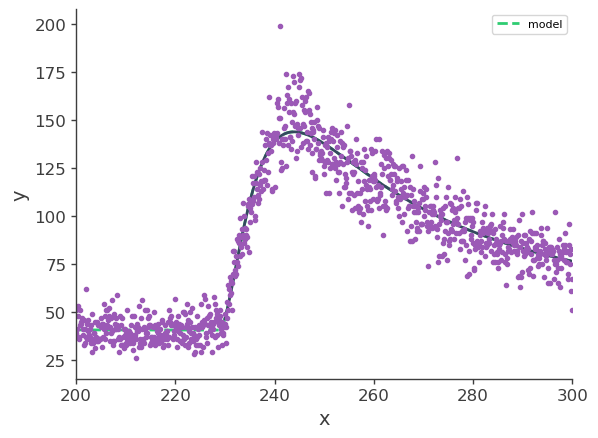

In [42]:
%matplotlib inline
GRBlike.plot()
xx = np.arange(230,300,0.001)
yy = lcmodelf(xx)
plt.xlim(200,300)
plt.plot(xx,yy)
plt.show()

In [45]:
jl = JointLikelihood(model2, data)
best_fit_parameters, likelihood_values = jl.fit()

10:19:20 INFO      set the minimizer to minuit                                             ]8;id=639890;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=370845;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

Best fit values:

,result,unit
parameter,,
GRB221009A2.spectrum.main.composite.F0_1,(1.74 -0.21 +0.25) x 10^2,1 / (keV s cm2)
GRB221009A2.spectrum.main.composite.tb_1,(1.56 +/- 0.07) x 10,keV
GRB221009A2.spectrum.main.composite.omega_1,1.33 +/- 0.34,
GRB221009A2.spectrum.main.composite.alpha1_1,(8.8 +/- 1.3) x 10^-1,
GRB221009A2.spectrum.main.composite.alpha2_1,-1.12 +/- 0.08,
GRB221009A2.spectrum.main.composite.t0_1,(2.2986 +/- 0.0030) x 10^2,keV
GRB221009A2.spectrum.main.composite.a_2,(4.08 +/- 0.05) x 10,1 / (keV s cm2)
GRB221009A2.spectrum.main.composite.b_2,(-2.7 +/- 2.0) x 10^-3,1 / (s cm2 keV2)
GRB221009A2.spectrum.main.composite.F_3,(6.0 +/- 1.1) x 10^2,1 / (s cm2)


Correlation matrix:

1.00,-0.14,-0.99,0.86,-0.87,-0.64,-0.28,0.62,-0.48,0.60,0.39
-0.14,1.00,0.08,-0.52,-0.32,0.41,-0.10,0.30,-0.11,0.42,0.16
-0.99,0.08,1.00,-0.82,0.89,0.60,0.30,-0.64,0.45,-0.60,-0.42
0.86,-0.52,-0.82,1.00,-0.57,-0.88,-0.19,0.38,-0.31,0.32,0.25
-0.87,-0.32,0.89,-0.57,1.00,0.40,0.35,-0.80,0.37,-0.80,-0.44
-0.64,0.41,0.60,-0.88,0.40,1.00,0.10,-0.24,0.28,-0.26,-0.11
-0.28,-0.10,0.30,-0.19,0.35,0.10,1.00,-0.78,-0.39,-0.12,-0.65
0.62,0.30,-0.64,0.38,-0.80,-0.24,-0.78,1.00,0.09,0.59,0.57
-0.48,-0.11,0.45,-0.31,0.37,0.28,-0.39,0.09,1.00,-0.37,0.21
0.60,0.42,-0.60,0.32,-0.80,-0.26,-0.12,0.59,-0.37,1.00,0.24
0.39,0.16,-0.42,0.25,-0.44,-0.11,-0.65,0.57,0.21,0.24,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
GRB221009A,15398.988944
total,15398.988944


Values of statistical measures:

,statistical measures
AIC,30820.036711
BIC,30890.508047


  * description: A  SBPL
  * formula: $  F0 * pow(pow((x - t0) / tb, -omega * alpha1) + pow((x - t0) / tb, -omega
    * * alpha2), -1 / omega) $
  * parameters:
    * F0_1:
      * value: 173.64063824551874
      * desc: Normalization
      * min_value: 0.1
      * max_value: 1000.0
      * unit: keV-1 s-1 cm-2
      * is_normalization: true
      * delta: 0.1
      * free: true
    * tb_1:
      * value: 15.627168717695051
      * desc: break time
      * min_value: null
      * max_value: null
      * unit: keV
      * is_normalization: false
      * delta: 1.0
      * free: true
    * omega_1:
      * value: 1.3262570821612658
      * desc: break smooth
      * min_value: 0.0
      * max_value: null
      * unit: ''
      * is_normalization: false
      * delta: 0.1
      * free: true
    * alpha1_1:
      * value: 0.8776990340711974
      * desc: index 1
      * min_value: 0.0
      * max_value: 5.0
      * unit: ''
      * is_normalization: false
      * delta: 0.1
      * free: t

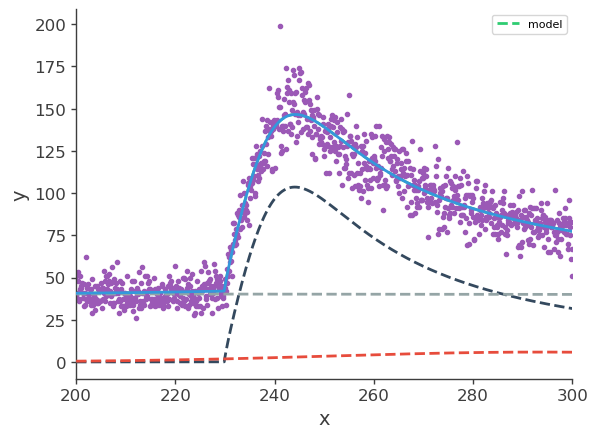

In [56]:
%matplotlib inline
GRBlike.plot()
xx = np.arange(200,300,0.001)
yy = lcmodelf2(xx)
for i in range(len(lcmodelf2.functions)):
    yy2 = lcmodelf2.functions[i](xx)
    plt.plot(xx,yy2, "--", zorder=4)
plt.xlim(200,300)
plt.plot(xx,yy,zorder=4)
plt.show()